In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests





class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

In [3]:
# Train data:
data['observation_value_matrix']
metadata["observation_ids"]
metadata["observation_timestamps"]

data['action_value_matrix']
metadata["action_ids"]

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']
metadata_val["action_ids"]
metadata_val["observation_timestamps"]
floorplan
device_layout_map

exogenous_observation_data
exogenous_observation_data_ids
initial_condition

# Predict:
temp_data
temp_data_ids







{'2760348383893915@zone_air_temperature_sensor': 0,
 '2562701969438717@zone_air_temperature_sensor': 1,
 '2806035809406684@zone_air_temperature_sensor': 2,
 '2790439929052995@zone_air_temperature_sensor': 3,
 '2628534928204590@zone_air_temperature_sensor': 4,
 '2535333053617205@zone_air_temperature_sensor': 5,
 '2619255661594253@zone_air_temperature_sensor': 6,
 '2618781414146613@zone_air_temperature_sensor': 7,
 '2613654138967436@zone_air_temperature_sensor': 8,
 '2762982574975969@zone_air_temperature_sensor': 9,
 '2578499186529204@zone_air_temperature_sensor': 10,
 '2693289483686059@zone_air_temperature_sensor': 11,
 '2549483694528743@zone_air_temperature_sensor': 12,
 '2614466029028994@zone_air_temperature_sensor': 13,
 '2760979770441910@zone_air_temperature_sensor': 14,
 '2732460999450017@zone_air_temperature_sensor': 15,
 '2549513081490212@zone_air_temperature_sensor': 16,
 '2737293899563066@zone_air_temperature_sensor': 17,
 '2710040674126014@zone_air_temperature_sensor': 18,
 '2

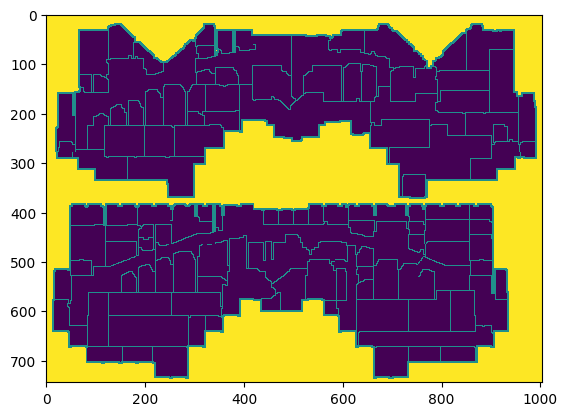

In [4]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [5]:
metadata["device_infos"][0]


{'device_id': '202194278473007104',
 'namespace': 'PHRED',
 'code': 'SB1:AHU:AC-2',
 'zone_id': '',
 'device_type': 6,
 'observable_fields': {'building_air_static_pressure_sensor': 1,
  'outside_air_flowrate_sensor': 1,
  'supply_fan_speed_percentage_command': 1,
  'supply_air_temperature_sensor': 1,
  'supply_fan_speed_frequency_sensor': 1,
  'supply_air_static_pressure_setpoint': 1,
  'return_air_temperature_sensor': 1,
  'mixed_air_temperature_setpoint': 1,
  'exhaust_fan_speed_percentage_command': 1,
  'exhaust_fan_speed_frequency_sensor': 1,
  'outside_air_damper_percentage_command': 1,
  'mixed_air_temperature_sensor': 1,
  'exhaust_air_damper_percentage_command': 1,
  'cooling_percentage_command': 1,
  'outside_air_flowrate_setpoint': 1,
  'supply_air_temperature_setpoint': 1,
  'building_air_static_pressure_setpoint': 1,
  'supply_air_static_pressure_sensor': 1},
 'action_fields': {'exhaust_air_damper_percentage_command': 1,
  'supply_air_temperature_setpoint': 1,
  'supply_fan

In [6]:
metadata["zone_infos"][0]


{'zone_id': 'rooms/1002000133978',
 'building_id': 'buildings/3616672508',
 'zone_description': 'SB1-2-C2054',
 'area': 0.0,
 'zone_type': 1,
 'floor': 2,
 'devices': ['2618581107144046', '2696593986887004']}

In [7]:
temp_data.shape

(53292, 123)

In [8]:
print((temp_data==0).sum()/(temp_data.shape[0]*temp_data.shape[1]))

0.10406372865800263


In [9]:
indexes1 = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_train = data['observation_value_matrix'][:, indexes1]

(temp_data_train==0).sum()/(temp_data_train.shape[0]*temp_data_train.shape[1])

0.28568066460576663

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def kelvin_to_fahrenheit(temp_k):
    """Convert temperature from Kelvin to Fahrenheit"""
    return (temp_k - 273.15) * 9/5 + 32

def preprocess_temperatures(data_matrix, metadata_dict, data_name="data"):
    """
    Preprocess temperature data by converting Kelvin to Fahrenheit
    
    Args:
        data_matrix: numpy array of observation data
        metadata_dict: dictionary containing observation_ids mapping
        data_name: string name for logging purposes

    Returns:
        data_matrix: preprocessed data matrix (modified in-place)
        temp_conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    # Find temperature-related observation IDs
    temp_sensor_ids = []
    temp_setpoint_ids = []
    
    for obs_name, obs_idx in metadata_dict.items():
        if any(temp_keyword in obs_name.lower() for temp_keyword in [
            'temperature_sensor', 'temperature_setpoint', 
            'air_temperature', 'mixed_air_temperature',
            'supply_air_temperature', 'return_air_temperature',
            'discharge_air_temperature', 'outside_air_temperature'
        ]):
            if 'sensor' in obs_name:
                temp_sensor_ids.append((obs_name, obs_idx))
            elif 'setpoint' in obs_name:
                temp_setpoint_ids.append((obs_name, obs_idx))
            else:
                # Default to sensor if unclear
                temp_sensor_ids.append((obs_name, obs_idx))
    
    print(f"Found {len(temp_sensor_ids)} temperature sensors")
    print(f"Found {len(temp_setpoint_ids)} temperature setpoints")
    
    conversion_info = {
        'sensors_converted': 0,
        'setpoints_converted': 0,
        'total_values_converted': 0,
        'sensor_details': [],
        'setpoint_details': []
    }
    
    # Process temperature sensors
    for obs_name, obs_idx in temp_sensor_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    # Process temperature setpoints
    for obs_name, obs_idx in temp_setpoint_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['setpoints_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['setpoint_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Temperature setpoints converted: {conversion_info['setpoints_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return data_matrix, conversion_info

def preprocess_temp_data_array(temp_data_array, temp_data_ids, data_name="temperature data"):
    """
    Preprocess temperature data array (for validation temperature data)
    
    Args:
        temp_data_array: numpy array of temperature data
        temp_data_ids: dictionary mapping temperature sensor names to column indices
        data_name: string name for logging purposes

    Returns:
        temp_data_array: preprocessed temperature data (modified in-place)
        conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    conversion_info = {
        'sensors_converted': 0,
        'total_values_converted': 0,
        'sensor_details': []
    }
    
    for sensor_name, col_idx in temp_data_ids.items():
        temp_values = temp_data_array[:, col_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {sensor_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            temp_data_array[kelvin_mask, col_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={temp_data_array[kelvin_mask, col_idx].min():.2f}, max={temp_data_array[kelvin_mask, col_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': sensor_name,
                'index': col_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return temp_data_array, conversion_info

def remove_zero_temperature_readings(obs_matrix, temp_data_matrix, exog_data_matrix, 
                                   timestamps_train, timestamps_val, metadata_obs_ids, 
                                   temp_data_ids, exog_data_ids):
    """
    Remove rows where temperature sensors have zero values from both training and validation sets
    
    Args:
        obs_matrix: training observation matrix
        temp_data_matrix: validation temperature data matrix  
        exog_data_matrix: validation exogenous data matrix
        timestamps_train: training timestamps
        timestamps_val: validation timestamps
        metadata_obs_ids: training observation IDs mapping
        temp_data_ids: validation temperature IDs mapping
        exog_data_ids: validation exogenous IDs mapping

    Returns:
        Cleaned datasets with zero temperature readings removed
    """
    
    print("\n" + "="*60)
    print("REMOVING ZERO TEMPERATURE READINGS")
    print("="*60)
    
    # 1. Clean training data
    print("\nCleaning training data...")
    
    # Find temperature sensor columns in training data
    train_temp_indices = [v for k, v in metadata_obs_ids.items() 
                         if "zone_air_temperature_sensor" in k]
    
    # Get temperature data from training matrix
    train_temp_data = obs_matrix[:, train_temp_indices]
    
    # Find rows where ANY temperature sensor has zero values
    zero_mask_train = np.any(train_temp_data == 0, axis=1)
    valid_mask_train = ~zero_mask_train
    
    print(f"  Original training data: {len(obs_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_train)}")
    print(f"  Rows to keep: {np.sum(valid_mask_train)}")
    print(f"  Percentage kept: {np.sum(valid_mask_train)/len(obs_matrix)*100:.1f}%")
    
    # Apply mask to training data
    obs_matrix_clean = obs_matrix[valid_mask_train]
    timestamps_train_clean = [timestamps_train[i] for i in range(len(timestamps_train)) if valid_mask_train[i]]
    
    # 2. Clean validation data
    print("\nCleaning validation data...")
    
    # Find rows where ANY temperature sensor has zero values in validation
    zero_mask_val = np.any(temp_data_matrix == 0, axis=1)
    valid_mask_val = ~zero_mask_val
    
    print(f"  Original validation data: {len(temp_data_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_val)}")
    print(f"  Rows to keep: {np.sum(valid_mask_val)}")
    print(f"  Percentage kept: {np.sum(valid_mask_val)/len(temp_data_matrix)*100:.1f}%")
    
    # Apply mask to validation data
    temp_data_clean = temp_data_matrix[valid_mask_val]
    exog_data_clean = exog_data_matrix[valid_mask_val]
    timestamps_val_clean = [timestamps_val[i] for i in range(len(timestamps_val)) if valid_mask_val[i]]
    
    print(f"\nData cleaning summary:")
    print(f"  Training: {len(obs_matrix)} -> {len(obs_matrix_clean)} rows")
    print(f"  Validation: {len(temp_data_matrix)} -> {len(temp_data_clean)} rows")
    
    return (obs_matrix_clean, temp_data_clean, exog_data_clean, 
            timestamps_train_clean, timestamps_val_clean)

# ===== MAIN PREPROCESSING STEP =====
print("Starting temperature preprocessing...")

# First, extract arrays from NpzFile objects to make them modifiable
print("Extracting arrays from NpzFile objects...")

# Extract training observation matrix (make it modifiable)
train_obs_matrix = np.array(data['observation_value_matrix'])
print(f"Training observation matrix shape: {train_obs_matrix.shape}")

# Extract validation exogenous data (make it modifiable) 
val_exog_matrix = np.array(exogenous_observation_data)
print(f"Validation exogenous matrix shape: {val_exog_matrix.shape}")

# Extract validation temperature data (make it modifiable)
val_temp_matrix = np.array(temp_data)
print(f"Validation temperature matrix shape: {val_temp_matrix.shape}")

# 1. Preprocess training data (observation_value_matrix)
print("\n" + "="*60)
print("PREPROCESSING TRAINING DATA")
print("="*60)

train_obs_matrix, train_conversion_info = preprocess_temperatures(
    train_obs_matrix, 
    metadata['observation_ids'], 
    "training data"
)

# 2. Preprocess validation exogenous data
print("\n" + "="*60)
print("PREPROCESSING VALIDATION EXOGENOUS DATA")
print("="*60)

val_exog_matrix, val_exog_conversion_info = preprocess_temperatures(
    val_exog_matrix, 
    exogenous_observation_data_ids, 
    "validation exogenous data"
)

# 3. Preprocess validation temperature data (targets)
print("\n" + "="*60)
print("PREPROCESSING VALIDATION TEMPERATURE DATA (TARGETS)")
print("="*60)

val_temp_matrix, val_temp_conversion_info = preprocess_temp_data_array(
    val_temp_matrix, 
    temp_data_ids, 
    "validation temperature targets"
)

# 4. Remove zero temperature readings from both training and validation
print("\n" + "="*60)
print("REMOVING ZERO TEMPERATURE READINGS")
print("="*60)

# Remove rows with zero temperature readings
(train_obs_matrix_clean, val_temp_matrix_clean, val_exog_matrix_clean, 
 timestamps_train_clean, timestamps_val_clean) = remove_zero_temperature_readings(
    train_obs_matrix, val_temp_matrix, val_exog_matrix,
    metadata["observation_timestamps"], metadata_val["observation_timestamps"],
    metadata['observation_ids'], temp_data_ids, exogenous_observation_data_ids
)

print("\n" + "="*60)
print("TEMPERATURE PREPROCESSING COMPLETED")
print("="*60)

# Print overall summary
total_converted = (train_conversion_info['total_values_converted'] + 
                  val_exog_conversion_info['total_values_converted'] + 
                  val_temp_conversion_info['total_values_converted'])

print(f"\nOVERALL CONVERSION SUMMARY:")
print(f"  Training data: {train_conversion_info['total_values_converted']} values converted")
print(f"  Validation exogenous: {val_exog_conversion_info['total_values_converted']} values converted")
print(f"  Validation targets: {val_temp_conversion_info['total_values_converted']} values converted")
print(f"  TOTAL: {total_converted} temperature values converted from Kelvin to Fahrenheit")

print(f"\nOVERALL ZERO REMOVAL SUMMARY:")
print(f"  Training data: {len(train_obs_matrix)} -> {len(train_obs_matrix_clean)} rows")
print(f"  Validation data: {len(val_temp_matrix)} -> {len(val_temp_matrix_clean)} rows")

# Update the global variables to use the cleaned, preprocessed data
print("\nUpdating global variables with cleaned and preprocessed data...")
exogenous_observation_data = val_exog_matrix_clean
temp_data = val_temp_matrix_clean

print("Preprocessing complete! Now starting model training with PCA...")

# ===== MODEL WITH PCA =====

class SmartBuildingsPredictor:
    def __init__(self, use_gpu=True, n_pca_components=20):
        self.use_gpu = use_gpu
        self.n_pca_components = n_pca_components
        self.models = {}  # Will store 24 hourly models
        self.scalers = {}  # Will store scalers for each hour
        self.pca = None  # Will store PCA transformer
        self.imputer = None  # Will store imputer for NaN handling
        self.feature_columns = None
        self.temp_columns = None
        
    def interpolate_zeros(self, data):
        """Interpolate zero values in training data"""
        data_df = pd.DataFrame(data)
        # Replace zeros with NaN for interpolation
        data_df = data_df.replace(0, np.nan)
        # Forward fill then backward fill
        data_df = data_df.fillna(method='ffill').fillna(method='bfill')
        # If still NaN, fill with column mean
        data_df = data_df.fillna(data_df.mean())
        return data_df.values
    
    def handle_nan_values(self, exog_data, is_training=True):
        """Handle NaN values in exogenous data"""
        nan_count = np.isnan(exog_data).sum()
        
        if is_training:
            # Always fit imputer on training data (even if no NaN values)
            # This ensures imputer is available for test data that might have NaN values
            self.imputer = SimpleImputer(strategy='mean')
            exog_data_clean = self.imputer.fit_transform(exog_data)
            print(f"Fitted imputer on training data (found {nan_count} NaN values, {nan_count/exog_data.size*100:.2f}%)")
        else:
            # Use fitted imputer on test data
            if self.imputer is None:
                raise ValueError("Imputer not fitted yet. Train model first.")
            print(f"Found {nan_count} NaN values in test data ({nan_count/exog_data.size*100:.2f}%)")
            exog_data_clean = self.imputer.transform(exog_data)
            print("Applied fitted imputer to test data")
        
        nan_count_after = np.isnan(exog_data_clean).sum()
        print(f"NaN values after imputation: {nan_count_after}")
        return exog_data_clean
    
    def create_temporal_features(self, timestamps):
        """Create temporal dummy features"""
        features = []
        
        for ts in timestamps:
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                dt = ts
            else:  # Unix timestamp
                dt = datetime.fromtimestamp(ts)
            
            # Hour of day (0-23)
            hour = dt.hour
            
            # Time of day categories
            if 6 <= hour < 12:
                time_of_day = [1, 0, 0, 0]  # morning
            elif 12 <= hour < 18:
                time_of_day = [0, 1, 0, 0]  # day
            elif 18 <= hour < 22:
                time_of_day = [0, 0, 1, 0]  # evening
            else:
                time_of_day = [0, 0, 0, 1]  # night
            
            # Season
            month = dt.month
            if month in [12, 1, 2]:
                season = [1, 0, 0, 0]  # winter
            elif month in [3, 4, 5]:
                season = [0, 1, 0, 0]  # spring
            elif month in [6, 7, 8]:
                season = [0, 0, 1, 0]  # summer
            else:
                season = [0, 0, 0, 1]  # fall
            
            # Weekend/weekday
            is_weekend = 1 if dt.weekday() >= 5 else 0
            
            # Day of week (one-hot)
            day_of_week = [0] * 7
            day_of_week[dt.weekday()] = 1
            
            # Combine all features
            feature_row = [hour] + time_of_day + season + [is_weekend] + day_of_week
            features.append(feature_row)
        
        feature_names = ['hour'] + \
                       ['morning', 'day', 'evening', 'night'] + \
                       ['winter', 'spring', 'summer', 'fall'] + \
                       ['is_weekend'] + \
                       [f'dow_{i}' for i in range(7)]
        
        return np.array(features), feature_names
    
    def fit_pca(self, exog_data):
        """Fit PCA on exogenous features"""
        print(f"Fitting PCA on exogenous features...")
        print(f"Original exogenous features: {exog_data.shape[1]}")
        
        # Fit PCA
        self.pca = PCA(n_components=self.n_pca_components, random_state=42)
        self.pca.fit(exog_data)
        
        explained_variance_ratio = np.sum(self.pca.explained_variance_ratio_)
        print(f"PCA components: {self.n_pca_components}")
        print(f"Explained variance ratio: {explained_variance_ratio:.4f}")
        
    def transform_exog_data(self, exog_data):
        """Transform exogenous data using fitted PCA"""
        if self.pca is None:
            raise ValueError("PCA not fitted yet. Call fit_pca first.")
        
        return self.pca.transform(exog_data)
    
    def prepare_data(self, obs_data, exog_data, timestamps, temp_data=None, is_training=True):
        """Prepare data with interpolation, NaN handling, PCA, and feature engineering"""
        
        # Interpolate training data
        if is_training:
            obs_data = self.interpolate_zeros(obs_data) if obs_data is not None else None
            temp_data = self.interpolate_zeros(temp_data) if temp_data is not None else None
        
        # Create temporal features
        temporal_features, temporal_names = self.create_temporal_features(timestamps)
        
        # Apply NaN handling and PCA to exogenous features
        if exog_data is not None:
            # Handle NaN values first
            exog_data_clean = self.handle_nan_values(exog_data, is_training=is_training)
            
            if is_training and self.pca is None:
                # Fit PCA on training data
                self.fit_pca(exog_data_clean)
            
            # Transform exogenous data using PCA
            exog_pca = self.transform_exog_data(exog_data_clean)
            exog_names = [f'pca_{i}' for i in range(exog_pca.shape[1])]
            
            # Combine PCA features and temporal features
            X = np.hstack([exog_pca, temporal_features])
            feature_names = exog_names + temporal_names
        else:
            X = temporal_features
            feature_names = temporal_names
        
        return X, feature_names, temp_data
    
    def create_hourly_bins(self, X, y, timestamps):
        """Create hourly bins for data"""
        hourly_data = {}
        
        for i, ts in enumerate(timestamps):
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                hour = ts.hour
            else:  # Unix timestamp
                hour = datetime.fromtimestamp(ts).hour
                
            if hour not in hourly_data:
                hourly_data[hour] = {'X': [], 'y': []}
            hourly_data[hour]['X'].append(X[i])
            if y is not None:
                hourly_data[hour]['y'].append(y[i])
        
        # Convert to numpy arrays
        for hour in hourly_data:
            hourly_data[hour]['X'] = np.array(hourly_data[hour]['X'])
            if y is not None:
                hourly_data[hour]['y'] = np.array(hourly_data[hour]['y'])
        
        return hourly_data
    
    def optimize_hyperparameters(self, X_train, y_train, trial):
        """Optuna objective function for hyperparameter optimization"""
        params = {
            'objective': 'reg:absoluteerror',  # MAE objective
            'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
            'random_state': 42,
            'n_jobs': 1
        }
        
        base_model = xgb.XGBRegressor(**params)
        model = MultiOutputRegressor(base_model, n_jobs=1)
        
        # Simple train/validation split for optimization
        split_idx = int(0.8 * len(X_train))
        X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
        y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        return mean_absolute_error(y_val, y_pred)
    
    def train_hourly_models(self, X_train, y_train, timestamps_train, n_trials=3):
        """Train 24 hourly XGBoost models with hyperparameter optimization"""
        
        # Create hourly bins
        hourly_train_data = self.create_hourly_bins(X_train, y_train, timestamps_train)
        
        print(f"Training {len(hourly_train_data)} hourly models...")
        
        for hour in range(24):
            if hour not in hourly_train_data:
                print(f"No data for hour {hour}, skipping...")
                continue
                
            print(f"Training model for hour {hour}...")
            
            X_hour = hourly_train_data[hour]['X']
            y_hour = hourly_train_data[hour]['y']
            
            if len(X_hour) < 10:
                print(f"Too few samples for hour {hour} ({len(X_hour)}), skipping...")
                continue
            
            # Scale features
            scaler = StandardScaler()
            X_hour_scaled = scaler.fit_transform(X_hour)
            self.scalers[hour] = scaler
            
            # Optimize hyperparameters
            study = optuna.create_study(direction='minimize', study_name=f'hour_{hour}')
            
            def objective(trial):
                return self.optimize_hyperparameters(X_hour_scaled, y_hour, trial)
            
            study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
            
            # Train final model with best parameters
            best_params = study.best_params
            best_params.update({
                'objective': 'reg:absoluteerror',
                'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
                'random_state': 42,
                'n_jobs': 1
            })
            
            base_model = xgb.XGBRegressor(**best_params)
            model = MultiOutputRegressor(base_model, n_jobs=1)
            model.fit(X_hour_scaled, y_hour)
            
            self.models[hour] = model
            
            print(f"Hour {hour} - Best MAE: {study.best_value:.4f}")
        
        print(f"Training completed. {len(self.models)} models trained.")
    
    def predict(self, X_test, timestamps_test):
        """Make predictions using hourly models"""
        first_model = self.models[list(self.models.keys())[0]]
        n_outputs = len(first_model.estimators_)
        
        predictions = np.zeros((len(X_test), n_outputs))
        
        # Create hourly bins for test data
        hourly_test_data = self.create_hourly_bins(X_test, None, timestamps_test)
        
        for hour in hourly_test_data:
            if hour not in self.models:
                available_hours = list(self.models.keys())
                hour_to_use = min(available_hours, key=lambda x: abs(x - hour))
                print(f"Using model for hour {hour_to_use} instead of hour {hour}")
            else:
                hour_to_use = hour
            
            X_hour = hourly_test_data[hour]['X']
            X_hour_scaled = self.scalers[hour_to_use].transform(X_hour)
            
            hour_predictions = self.models[hour_to_use].predict(X_hour_scaled)
            
            # Map predictions back to original indices
            hour_indices = []
            for i, ts in enumerate(timestamps_test):
                if hasattr(ts, 'hour'):
                    ts_hour = ts.hour
                else:
                    ts_hour = datetime.fromtimestamp(ts).hour
                    
                if ts_hour == hour:
                    hour_indices.append(i)
            
            for i, idx in enumerate(hour_indices):
                predictions[idx] = hour_predictions[i]
        
        return predictions
    
    def evaluate_predictions(self, y_true, y_pred, timestamps_test):
        """Evaluate predictions for different time periods"""
        results = {}
        
        # Convert timestamps to datetime for easier handling
        dates = []
        for ts in timestamps_test:
            if hasattr(ts, 'to_pydatetime'):
                dates.append(ts.to_pydatetime())
            elif hasattr(ts, 'hour'):
                dates.append(ts)
            else:
                dates.append(datetime.fromtimestamp(ts))
        
        start_date = min(dates)
        
        # Define evaluation periods
        periods = {
            'first_week': timedelta(days=7),
            'first_2_weeks': timedelta(days=14),
            'first_month': timedelta(days=30),
            'first_3_months': timedelta(days=90),
            'entire_period': timedelta(days=365)
        }
        
        for period_name, period_length in periods.items():
            end_date = start_date + period_length
            
            period_indices = [i for i, date in enumerate(dates) if date <= end_date]
            
            if period_indices:
                y_true_period = y_true[period_indices]
                y_pred_period = y_pred[period_indices]
                
                mae = mean_absolute_error(y_true_period, y_pred_period)
                results[period_name] = mae
                print(f"{period_name}: MAE = {mae:.4f}")
        
        return results

# Main execution function
def run_smart_buildings_model():
    """Main function to run the complete model"""
    
    print("Initializing Smart Buildings Predictor with PCA and NaN handling...")
    predictor = SmartBuildingsPredictor(use_gpu=True, n_pca_components=20)
    
    # Prepare training data
    print("Preparing training data...")
    
    # Extract training temperature data (target) from cleaned preprocessed data
    train_temp_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" in k]
    train_temp_data = train_obs_matrix_clean[:, train_temp_indices]
    
    # Extract training exogenous data from cleaned preprocessed data
    train_exog_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" not in k]
    train_exog_data = train_obs_matrix_clean[:, train_exog_indices]
    
    # Prepare training features and targets using cleaned timestamps
    X_train, feature_names, y_train = predictor.prepare_data(
        None, train_exog_data, timestamps_train_clean, 
        train_temp_data, is_training=True
    )
    
    predictor.feature_columns = feature_names
    
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Feature names: {len(feature_names)} features")
    
    # Train models using cleaned timestamps with 5 trials
    predictor.train_hourly_models(X_train, y_train, timestamps_train_clean, n_trials=3)
    
    # Prepare test data using cleaned validation data
    print("Preparing test data...")
    X_test, _, _ = predictor.prepare_data(
        None, exogenous_observation_data, timestamps_val_clean, 
        None, is_training=False
    )
    
    print(f"Test data shape: {X_test.shape}")
    
    # Make predictions using cleaned validation timestamps
    print("Making predictions...")
    predictions = predictor.predict(X_test, timestamps_val_clean)
    
    print(f"Predictions shape: {predictions.shape}")
    print(f"True values shape: {temp_data.shape}")
    
    # Evaluate results using cleaned validation timestamps
    print("\nEvaluation Results:")
    print("=" * 50)
    results = predictor.evaluate_predictions(
        temp_data, predictions, timestamps_val_clean
    )
    
    return predictor, predictions, results

# Run the model
if __name__ == "__main__":
    predictor, predictions, results = run_smart_buildings_model()

Starting temperature preprocessing...
Extracting arrays from NpzFile objects...
Training observation matrix shape: (51852, 1198)
Validation exogenous matrix shape: (53292, 1075)
Validation temperature matrix shape: (53292, 123)

PREPROCESSING TRAINING DATA

=== Temperature Preprocessing for training data ===
Found 246 temperature sensors
Found 357 temperature setpoints
  Converting 36921/51852 values in 202194278473007104@return_air_temperature_sensor
    Before: min=284.43, max=307.39
    After:  min=52.30, max=93.64
  Converting 36921/51852 values in 202194278473007104@mixed_air_temperature_sensor
    Before: min=281.87, max=305.57
    After:  min=47.69, max=90.35
  Converting 36921/51852 values in 202194278473007104@supply_air_temperature_sensor
    Before: min=280.11, max=305.19
    After:  min=44.53, max=89.67
  Converting 36758/51852 values in 2291864505572917248@outside_air_wetbulb_temperature_sensor
    Before: min=273.01, max=293.60
    After:  min=31.74, max=68.82
  Convertin

[I 2025-07-05 00:05:34,388] A new study created in memory with name: hour_0


Training 24 hourly models...
Training model for hour 0...


[I 2025-07-05 00:07:46,928] Trial 0 finished with value: 1.907352190719879 and parameters: {'n_estimators': 486, 'max_depth': 4, 'learning_rate': 0.08441890404788341, 'subsample': 0.8614641752123751, 'colsample_bytree': 0.6058442073967859, 'reg_alpha': 8.325194320761518, 'reg_lambda': 5.149915822893638}. Best is trial 0 with value: 1.907352190719879.
[I 2025-07-05 00:10:51,598] Trial 1 finished with value: 1.7515446848221201 and parameters: {'n_estimators': 313, 'max_depth': 8, 'learning_rate': 0.03459816681376177, 'subsample': 0.6253434310559434, 'colsample_bytree': 0.6374313690524347, 'reg_alpha': 4.321338401370516, 'reg_lambda': 9.724219309095632}. Best is trial 1 with value: 1.7515446848221201.
[I 2025-07-05 00:12:06,172] Trial 2 finished with value: 1.8480182666444402 and parameters: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.1371629025202439, 'subsample': 0.9921461443555746, 'colsample_bytree': 0.9924269546764544, 'reg_alpha': 0.45090691043572956, 'reg_lambda': 0.09

Hour 0 - Best MAE: 1.7515
Training model for hour 1...


[I 2025-07-05 00:16:16,311] Trial 0 finished with value: 2.238969999558188 and parameters: {'n_estimators': 156, 'max_depth': 5, 'learning_rate': 0.13967932510747078, 'subsample': 0.700768434152107, 'colsample_bytree': 0.9882732361870791, 'reg_alpha': 6.009047883652266, 'reg_lambda': 9.957804124086486}. Best is trial 0 with value: 2.238969999558188.
[I 2025-07-05 00:17:55,550] Trial 1 finished with value: 2.2530594985465693 and parameters: {'n_estimators': 178, 'max_depth': 7, 'learning_rate': 0.14286410107031294, 'subsample': 0.6925679118779081, 'colsample_bytree': 0.7507583009136198, 'reg_alpha': 7.5343372359238865, 'reg_lambda': 5.730760966122879}. Best is trial 0 with value: 2.238969999558188.
[I 2025-07-05 00:21:08,199] Trial 2 finished with value: 2.1502250197050325 and parameters: {'n_estimators': 425, 'max_depth': 6, 'learning_rate': 0.1668212505510008, 'subsample': 0.7725535092210484, 'colsample_bytree': 0.9354352729290742, 'reg_alpha': 4.910842859696416, 'reg_lambda': 7.53122

Hour 1 - Best MAE: 2.1502
Training model for hour 2...


[I 2025-07-05 00:26:23,825] Trial 0 finished with value: 2.044770148253367 and parameters: {'n_estimators': 272, 'max_depth': 6, 'learning_rate': 0.1673198400350364, 'subsample': 0.9551930324643849, 'colsample_bytree': 0.9867624344000635, 'reg_alpha': 7.602242691860338, 'reg_lambda': 1.6800664096442193}. Best is trial 0 with value: 2.044770148253367.
[I 2025-07-05 00:27:37,154] Trial 1 finished with value: 2.250053938115761 and parameters: {'n_estimators': 266, 'max_depth': 3, 'learning_rate': 0.1359195336787704, 'subsample': 0.7768524383003897, 'colsample_bytree': 0.8478257810931913, 'reg_alpha': 9.454975014850474, 'reg_lambda': 2.693165146357765}. Best is trial 0 with value: 2.044770148253367.
[I 2025-07-05 00:29:44,254] Trial 2 finished with value: 2.1060644335994114 and parameters: {'n_estimators': 290, 'max_depth': 6, 'learning_rate': 0.08531837728314759, 'subsample': 0.9740451934384727, 'colsample_bytree': 0.6847879539123796, 'reg_alpha': 2.1967211014038206, 'reg_lambda': 6.47518

Hour 2 - Best MAE: 2.0448
Training model for hour 3...


[I 2025-07-05 00:34:34,932] Trial 0 finished with value: 2.397610738612963 and parameters: {'n_estimators': 291, 'max_depth': 7, 'learning_rate': 0.2630381438365425, 'subsample': 0.9845286346658212, 'colsample_bytree': 0.7618688127687087, 'reg_alpha': 4.703946198095671, 'reg_lambda': 7.266509715631735}. Best is trial 0 with value: 2.397610738612963.
[I 2025-07-05 00:36:45,032] Trial 1 finished with value: 2.5527709441915025 and parameters: {'n_estimators': 402, 'max_depth': 4, 'learning_rate': 0.06279668751178583, 'subsample': 0.8626936569022412, 'colsample_bytree': 0.6206070566395018, 'reg_alpha': 4.267279826919711, 'reg_lambda': 6.794708415015787}. Best is trial 0 with value: 2.397610738612963.
[I 2025-07-05 00:41:35,615] Trial 2 finished with value: 2.380558826058205 and parameters: {'n_estimators': 442, 'max_depth': 8, 'learning_rate': 0.14425496425741652, 'subsample': 0.7992266585694124, 'colsample_bytree': 0.8271979229090536, 'reg_alpha': 6.931226825962688, 'reg_lambda': 1.957183

Hour 3 - Best MAE: 2.3806
Training model for hour 4...


[I 2025-07-05 00:49:06,278] Trial 0 finished with value: 2.577029475514482 and parameters: {'n_estimators': 363, 'max_depth': 5, 'learning_rate': 0.041934687684902563, 'subsample': 0.8157334159785806, 'colsample_bytree': 0.9301393893473828, 'reg_alpha': 2.5281731233487683, 'reg_lambda': 0.9851989560964558}. Best is trial 0 with value: 2.577029475514482.
[I 2025-07-05 00:50:19,330] Trial 1 finished with value: 2.6681359848220514 and parameters: {'n_estimators': 177, 'max_depth': 5, 'learning_rate': 0.29600273281384837, 'subsample': 0.9358162197032723, 'colsample_bytree': 0.6409201577191356, 'reg_alpha': 4.750719544749217, 'reg_lambda': 2.8912937470380684}. Best is trial 0 with value: 2.577029475514482.
[I 2025-07-05 00:52:47,156] Trial 2 finished with value: 2.699519982523626 and parameters: {'n_estimators': 372, 'max_depth': 5, 'learning_rate': 0.13627404096968998, 'subsample': 0.7600758954905931, 'colsample_bytree': 0.6862261941465936, 'reg_alpha': 3.9440337350053767, 'reg_lambda': 5.

Hour 4 - Best MAE: 2.5770
Training model for hour 5...


[I 2025-07-05 00:56:41,538] Trial 0 finished with value: 2.8021094626237417 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1536501877906352, 'subsample': 0.8057728502638131, 'colsample_bytree': 0.6744854768861628, 'reg_alpha': 8.151335644118374, 'reg_lambda': 1.3975159895106513}. Best is trial 0 with value: 2.8021094626237417.
[I 2025-07-05 00:58:13,438] Trial 1 finished with value: 2.727977732819365 and parameters: {'n_estimators': 163, 'max_depth': 7, 'learning_rate': 0.049217632568098926, 'subsample': 0.7298246079825313, 'colsample_bytree': 0.7983764827724894, 'reg_alpha': 4.540663064636922, 'reg_lambda': 2.70685185278409}. Best is trial 1 with value: 2.727977732819365.
[I 2025-07-05 01:02:13,154] Trial 2 finished with value: 2.795857943108086 and parameters: {'n_estimators': 437, 'max_depth': 7, 'learning_rate': 0.1399583501252861, 'subsample': 0.6904937807825162, 'colsample_bytree': 0.662644094969151, 'reg_alpha': 7.813923677004537, 'reg_lambda': 6.337335

Hour 5 - Best MAE: 2.7280
Training model for hour 6...


[I 2025-07-05 01:08:39,793] Trial 0 finished with value: 2.653716627894473 and parameters: {'n_estimators': 497, 'max_depth': 7, 'learning_rate': 0.0804260628269705, 'subsample': 0.6472153479965648, 'colsample_bytree': 0.9497216713068583, 'reg_alpha': 5.783898255890641, 'reg_lambda': 9.399820494665255}. Best is trial 0 with value: 2.653716627894473.
[I 2025-07-05 01:12:15,123] Trial 1 finished with value: 2.8162587163305877 and parameters: {'n_estimators': 318, 'max_depth': 8, 'learning_rate': 0.16740572370880985, 'subsample': 0.8268035876315204, 'colsample_bytree': 0.7091183146408586, 'reg_alpha': 7.156085798351084, 'reg_lambda': 6.499451612733352}. Best is trial 0 with value: 2.653716627894473.
[I 2025-07-05 01:15:32,432] Trial 2 finished with value: 2.7771135043767163 and parameters: {'n_estimators': 331, 'max_depth': 7, 'learning_rate': 0.0559173390625053, 'subsample': 0.881850119310043, 'colsample_bytree': 0.7977973814502505, 'reg_alpha': 2.330833457409938, 'reg_lambda': 3.7192606

Hour 6 - Best MAE: 2.6537
Training model for hour 7...


[I 2025-07-05 01:21:22,905] Trial 0 finished with value: 3.0171112026485725 and parameters: {'n_estimators': 140, 'max_depth': 5, 'learning_rate': 0.22786623990312624, 'subsample': 0.9969402088701154, 'colsample_bytree': 0.8417968500430165, 'reg_alpha': 9.853992063546238, 'reg_lambda': 7.841601375365814}. Best is trial 0 with value: 3.0171112026485725.
[I 2025-07-05 01:22:32,276] Trial 1 finished with value: 3.5363690114355615 and parameters: {'n_estimators': 198, 'max_depth': 4, 'learning_rate': 0.018420397375136816, 'subsample': 0.7307610362729855, 'colsample_bytree': 0.7330123631797911, 'reg_alpha': 4.821579349523789, 'reg_lambda': 3.3088048629448803}. Best is trial 0 with value: 3.0171112026485725.
[I 2025-07-05 01:25:20,488] Trial 2 finished with value: 3.057440245024209 and parameters: {'n_estimators': 492, 'max_depth': 4, 'learning_rate': 0.15788863969711425, 'subsample': 0.8783473394700321, 'colsample_bytree': 0.913419864034333, 'reg_alpha': 1.445072685395755, 'reg_lambda': 7.8

Hour 7 - Best MAE: 3.0171
Training model for hour 8...


[I 2025-07-05 01:29:56,649] Trial 0 finished with value: 2.808124911404267 and parameters: {'n_estimators': 376, 'max_depth': 7, 'learning_rate': 0.1659937274239544, 'subsample': 0.8014186172256329, 'colsample_bytree': 0.7010861827851612, 'reg_alpha': 3.959431997757663, 'reg_lambda': 6.947647166722646}. Best is trial 0 with value: 2.808124911404267.
[I 2025-07-05 01:31:21,041] Trial 1 finished with value: 2.9150907820806373 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.06256994753726448, 'subsample': 0.6372545443502362, 'colsample_bytree': 0.658916956614384, 'reg_alpha': 6.965482700696426, 'reg_lambda': 0.9950964659802828}. Best is trial 0 with value: 2.808124911404267.
[I 2025-07-05 01:34:53,141] Trial 2 finished with value: 2.5743454877346963 and parameters: {'n_estimators': 360, 'max_depth': 7, 'learning_rate': 0.2106213433447336, 'subsample': 0.7203621892898695, 'colsample_bytree': 0.863405514707708, 'reg_alpha': 1.4253703371498063, 'reg_lambda': 6.550375

Hour 8 - Best MAE: 2.5743
Training model for hour 9...


[I 2025-07-05 01:39:25,981] Trial 0 finished with value: 3.086777410160881 and parameters: {'n_estimators': 160, 'max_depth': 5, 'learning_rate': 0.16532374239058736, 'subsample': 0.97394943355701, 'colsample_bytree': 0.9619465490821086, 'reg_alpha': 6.001969675870093, 'reg_lambda': 8.205642425636183}. Best is trial 0 with value: 3.086777410160881.
[I 2025-07-05 01:44:40,841] Trial 1 finished with value: 3.179194582559229 and parameters: {'n_estimators': 440, 'max_depth': 8, 'learning_rate': 0.0672532701080364, 'subsample': 0.9087042958324796, 'colsample_bytree': 0.8222071297022976, 'reg_alpha': 5.357550894036038, 'reg_lambda': 0.42346223281803463}. Best is trial 0 with value: 3.086777410160881.
[I 2025-07-05 01:48:13,074] Trial 2 finished with value: 3.141954347634251 and parameters: {'n_estimators': 371, 'max_depth': 7, 'learning_rate': 0.207419295541793, 'subsample': 0.6315375449534304, 'colsample_bytree': 0.7897520823513029, 'reg_alpha': 6.061822524278578, 'reg_lambda': 5.679318329

Hour 9 - Best MAE: 3.0868
Training model for hour 10...


[I 2025-07-05 01:50:21,093] Trial 0 finished with value: 3.5336233633918015 and parameters: {'n_estimators': 129, 'max_depth': 6, 'learning_rate': 0.051424338264429874, 'subsample': 0.8366775902373804, 'colsample_bytree': 0.6918952470305063, 'reg_alpha': 4.161881759005723, 'reg_lambda': 6.85182219795166}. Best is trial 0 with value: 3.5336233633918015.
[I 2025-07-05 01:53:10,690] Trial 1 finished with value: 3.4305698517049596 and parameters: {'n_estimators': 423, 'max_depth': 5, 'learning_rate': 0.1610003010388961, 'subsample': 0.8851661866736511, 'colsample_bytree': 0.7350012462724822, 'reg_alpha': 4.679110967501016, 'reg_lambda': 0.029807814680881457}. Best is trial 1 with value: 3.4305698517049596.
[I 2025-07-05 01:54:21,105] Trial 2 finished with value: 3.3841424717355912 and parameters: {'n_estimators': 238, 'max_depth': 3, 'learning_rate': 0.270178278473777, 'subsample': 0.8856617534912874, 'colsample_bytree': 0.6419523418181964, 'reg_alpha': 5.369138873717967, 'reg_lambda': 4.8

Hour 10 - Best MAE: 3.3841
Training model for hour 11...


[I 2025-07-05 01:58:25,063] Trial 0 finished with value: 3.285365533302318 and parameters: {'n_estimators': 251, 'max_depth': 8, 'learning_rate': 0.19872811145649025, 'subsample': 0.9473871710089796, 'colsample_bytree': 0.6924348089203738, 'reg_alpha': 5.851032557797117, 'reg_lambda': 3.5099728641140686}. Best is trial 0 with value: 3.285365533302318.
[I 2025-07-05 02:03:15,199] Trial 1 finished with value: 3.2130057449773375 and parameters: {'n_estimators': 492, 'max_depth': 7, 'learning_rate': 0.23356754250225806, 'subsample': 0.7718357731794555, 'colsample_bytree': 0.7596432209774674, 'reg_alpha': 3.0888932233685167, 'reg_lambda': 3.3585131135554964}. Best is trial 1 with value: 3.2130057449773375.
[I 2025-07-05 02:06:28,426] Trial 2 finished with value: 3.317757372560285 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.19496923110419936, 'subsample': 0.8396715481638898, 'colsample_bytree': 0.8012458704174699, 'reg_alpha': 1.278790937735931, 'reg_lambda': 8.5

Hour 11 - Best MAE: 3.2130
Training model for hour 12...


[I 2025-07-05 02:12:50,515] Trial 0 finished with value: 4.02172634918942 and parameters: {'n_estimators': 379, 'max_depth': 3, 'learning_rate': 0.1293476896038859, 'subsample': 0.7043223828957369, 'colsample_bytree': 0.8806655853723455, 'reg_alpha': 0.6892742968134751, 'reg_lambda': 6.86644568902823}. Best is trial 0 with value: 4.02172634918942.
[I 2025-07-05 02:13:33,214] Trial 1 finished with value: 3.9922068343621264 and parameters: {'n_estimators': 147, 'max_depth': 4, 'learning_rate': 0.19849296595885013, 'subsample': 0.7693596763765598, 'colsample_bytree': 0.672846270244504, 'reg_alpha': 4.638610081269459, 'reg_lambda': 6.28894948638467}. Best is trial 1 with value: 3.9922068343621264.
[I 2025-07-05 02:15:36,141] Trial 2 finished with value: 3.9045552290775634 and parameters: {'n_estimators': 375, 'max_depth': 5, 'learning_rate': 0.2828875308656333, 'subsample': 0.730373049659342, 'colsample_bytree': 0.6320791602019262, 'reg_alpha': 9.99532729830249, 'reg_lambda': 1.68339449436

Hour 12 - Best MAE: 3.9046
Training model for hour 13...


[I 2025-07-05 02:19:27,275] Trial 0 finished with value: 2.9974465814432367 and parameters: {'n_estimators': 253, 'max_depth': 6, 'learning_rate': 0.14070408991109173, 'subsample': 0.7547854915993844, 'colsample_bytree': 0.9197647002033558, 'reg_alpha': 7.452842608919559, 'reg_lambda': 3.708246101715448}. Best is trial 0 with value: 2.9974465814432367.
[I 2025-07-05 02:20:02,064] Trial 1 finished with value: 3.2931714159373473 and parameters: {'n_estimators': 134, 'max_depth': 3, 'learning_rate': 0.2978770050220527, 'subsample': 0.9575997204018956, 'colsample_bytree': 0.6289864523387972, 'reg_alpha': 7.294181622218453, 'reg_lambda': 9.498771727382167}. Best is trial 0 with value: 2.9974465814432367.
[I 2025-07-05 02:23:51,183] Trial 2 finished with value: 2.836540977774193 and parameters: {'n_estimators': 465, 'max_depth': 7, 'learning_rate': 0.04280158765979007, 'subsample': 0.7815127045093427, 'colsample_bytree': 0.8527483404154488, 'reg_alpha': 0.6873505843753767, 'reg_lambda': 1.29

Hour 13 - Best MAE: 2.8365
Training model for hour 14...


[I 2025-07-05 02:29:00,263] Trial 0 finished with value: 1.9422108340818505 and parameters: {'n_estimators': 146, 'max_depth': 7, 'learning_rate': 0.11190259872161745, 'subsample': 0.817516264608126, 'colsample_bytree': 0.9699206213286151, 'reg_alpha': 7.102951830356902, 'reg_lambda': 6.364238440069844}. Best is trial 0 with value: 1.9422108340818505.
[I 2025-07-05 02:33:00,681] Trial 1 finished with value: 1.9541954333027551 and parameters: {'n_estimators': 421, 'max_depth': 8, 'learning_rate': 0.02254977068834107, 'subsample': 0.685200955225542, 'colsample_bytree': 0.8907522777995571, 'reg_alpha': 6.49438101784145, 'reg_lambda': 5.493725744724111}. Best is trial 0 with value: 1.9422108340818505.
[I 2025-07-05 02:35:52,547] Trial 2 finished with value: 1.8969753747508298 and parameters: {'n_estimators': 372, 'max_depth': 7, 'learning_rate': 0.23088768245977914, 'subsample': 0.9443573215957325, 'colsample_bytree': 0.6523106099948336, 'reg_alpha': 0.33250490493123563, 'reg_lambda': 0.46

Hour 14 - Best MAE: 1.8970
Training model for hour 15...


[I 2025-07-05 02:40:43,228] Trial 0 finished with value: 1.5046517514208075 and parameters: {'n_estimators': 202, 'max_depth': 8, 'learning_rate': 0.29685926155594655, 'subsample': 0.6938758366226588, 'colsample_bytree': 0.9867485967926205, 'reg_alpha': 8.413123861084278, 'reg_lambda': 6.520747099592026}. Best is trial 0 with value: 1.5046517514208075.
[I 2025-07-05 02:41:52,245] Trial 1 finished with value: 1.4447914122068288 and parameters: {'n_estimators': 240, 'max_depth': 4, 'learning_rate': 0.25136144564740587, 'subsample': 0.610906965223683, 'colsample_bytree': 0.7491552116644327, 'reg_alpha': 7.690929556280935, 'reg_lambda': 1.1624206359436478}. Best is trial 1 with value: 1.4447914122068288.
[I 2025-07-05 02:44:40,407] Trial 2 finished with value: 1.3475129819277798 and parameters: {'n_estimators': 399, 'max_depth': 6, 'learning_rate': 0.054877550514377586, 'subsample': 0.6202625144326349, 'colsample_bytree': 0.9322032704842842, 'reg_alpha': 5.198272072287557, 'reg_lambda': 1.

Hour 15 - Best MAE: 1.3475
Training model for hour 16...


[I 2025-07-05 02:48:05,922] Trial 0 finished with value: 1.343625800683142 and parameters: {'n_estimators': 152, 'max_depth': 3, 'learning_rate': 0.2828206100414236, 'subsample': 0.9421303069320854, 'colsample_bytree': 0.9972484872668932, 'reg_alpha': 2.16130056665261, 'reg_lambda': 1.8360825961350318}. Best is trial 0 with value: 1.343625800683142.
[I 2025-07-05 02:49:06,102] Trial 1 finished with value: 1.3927071907390354 and parameters: {'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.07591606410939976, 'subsample': 0.9722764264073869, 'colsample_bytree': 0.7594863848468227, 'reg_alpha': 6.180771493349053, 'reg_lambda': 3.113578246695531}. Best is trial 0 with value: 1.343625800683142.
[I 2025-07-05 02:50:39,709] Trial 2 finished with value: 1.669116183315379 and parameters: {'n_estimators': 387, 'max_depth': 3, 'learning_rate': 0.010226546641057394, 'subsample': 0.8795416677960443, 'colsample_bytree': 0.6836986816195273, 'reg_alpha': 3.0287775949479014, 'reg_lambda': 1.1859

Hour 16 - Best MAE: 1.3436
Training model for hour 17...


[I 2025-07-05 02:54:31,637] Trial 0 finished with value: 1.8840046625814462 and parameters: {'n_estimators': 461, 'max_depth': 6, 'learning_rate': 0.291679783111909, 'subsample': 0.7109523454533843, 'colsample_bytree': 0.7534977076816091, 'reg_alpha': 0.2882032547976976, 'reg_lambda': 9.041006456653179}. Best is trial 0 with value: 1.8840046625814462.
[I 2025-07-05 02:58:57,313] Trial 1 finished with value: 1.84058352689252 and parameters: {'n_estimators': 419, 'max_depth': 8, 'learning_rate': 0.2756701299347186, 'subsample': 0.8945587513788871, 'colsample_bytree': 0.779507018954159, 'reg_alpha': 0.9953592362022365, 'reg_lambda': 3.755316944044074}. Best is trial 1 with value: 1.84058352689252.
[I 2025-07-05 03:00:01,763] Trial 2 finished with value: 1.659007689036134 and parameters: {'n_estimators': 261, 'max_depth': 3, 'learning_rate': 0.11831106280377802, 'subsample': 0.6860493916194862, 'colsample_bytree': 0.8595706392512152, 'reg_alpha': 9.302746883798667, 'reg_lambda': 8.28414350

Hour 17 - Best MAE: 1.6590
Training model for hour 18...


[I 2025-07-05 03:03:02,421] Trial 0 finished with value: 1.853205800107467 and parameters: {'n_estimators': 417, 'max_depth': 4, 'learning_rate': 0.10632481585319674, 'subsample': 0.6482441463540511, 'colsample_bytree': 0.696033943873184, 'reg_alpha': 1.0879246633895352, 'reg_lambda': 4.668308118693916}. Best is trial 0 with value: 1.853205800107467.
[I 2025-07-05 03:04:09,792] Trial 1 finished with value: 1.8039672760765522 and parameters: {'n_estimators': 276, 'max_depth': 3, 'learning_rate': 0.07661043656859354, 'subsample': 0.6049357834664475, 'colsample_bytree': 0.7702465698071335, 'reg_alpha': 5.675780530043666, 'reg_lambda': 5.51586169554725}. Best is trial 1 with value: 1.8039672760765522.
[I 2025-07-05 03:05:47,980] Trial 2 finished with value: 1.7181279904729136 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.1352551414810749, 'subsample': 0.9235742178818434, 'colsample_bytree': 0.9898071781667087, 'reg_alpha': 2.0888277750365747, 'reg_lambda': 3.2298

Hour 18 - Best MAE: 1.7181
Training model for hour 19...


[I 2025-07-05 03:08:36,950] Trial 0 finished with value: 1.9122774385810455 and parameters: {'n_estimators': 242, 'max_depth': 4, 'learning_rate': 0.01876474255183188, 'subsample': 0.6494169400410182, 'colsample_bytree': 0.6768841539807077, 'reg_alpha': 8.959602283781159, 'reg_lambda': 4.51941766811276}. Best is trial 0 with value: 1.9122774385810455.
[I 2025-07-05 03:10:34,199] Trial 1 finished with value: 1.7766776217450846 and parameters: {'n_estimators': 345, 'max_depth': 5, 'learning_rate': 0.03258843460436573, 'subsample': 0.8345897740093733, 'colsample_bytree': 0.7814784152574428, 'reg_alpha': 7.637307087345845, 'reg_lambda': 7.104362057834146}. Best is trial 1 with value: 1.7766776217450846.
[I 2025-07-05 03:11:52,251] Trial 2 finished with value: 1.837950963425665 and parameters: {'n_estimators': 322, 'max_depth': 3, 'learning_rate': 0.28457637094379085, 'subsample': 0.9510969652186996, 'colsample_bytree': 0.9486029132872678, 'reg_alpha': 5.051322604955798, 'reg_lambda': 8.416

Hour 19 - Best MAE: 1.7767
Training model for hour 20...


[I 2025-07-05 03:15:07,609] Trial 0 finished with value: 1.7813377701698374 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.22780651347940498, 'subsample': 0.848821297748575, 'colsample_bytree': 0.9597668419762799, 'reg_alpha': 6.787792607973376, 'reg_lambda': 9.861065940792953}. Best is trial 0 with value: 1.7813377701698374.
[I 2025-07-05 03:16:23,815] Trial 1 finished with value: 1.8172161317121223 and parameters: {'n_estimators': 316, 'max_depth': 3, 'learning_rate': 0.18057837494386478, 'subsample': 0.9131845334490224, 'colsample_bytree': 0.7580403252681973, 'reg_alpha': 5.84045380570769, 'reg_lambda': 8.768745670781575}. Best is trial 0 with value: 1.7813377701698374.
[I 2025-07-05 03:17:25,417] Trial 2 finished with value: 1.8223604565780611 and parameters: {'n_estimators': 254, 'max_depth': 3, 'learning_rate': 0.25353654983169266, 'subsample': 0.6965992673178603, 'colsample_bytree': 0.7499649587267361, 'reg_alpha': 5.904802499839963, 'reg_lambda': 1.590

Hour 20 - Best MAE: 1.7813
Training model for hour 21...


[I 2025-07-05 03:21:43,878] Trial 0 finished with value: 1.8724776803083154 and parameters: {'n_estimators': 321, 'max_depth': 8, 'learning_rate': 0.07157372837468015, 'subsample': 0.6418014820482671, 'colsample_bytree': 0.7144444180874849, 'reg_alpha': 7.751011413971128, 'reg_lambda': 8.472791916855506}. Best is trial 0 with value: 1.8724776803083154.
[I 2025-07-05 03:22:46,933] Trial 1 finished with value: 1.7849014656466384 and parameters: {'n_estimators': 258, 'max_depth': 3, 'learning_rate': 0.23078048988956348, 'subsample': 0.824949669308014, 'colsample_bytree': 0.9670683065456811, 'reg_alpha': 9.75940097341379, 'reg_lambda': 1.3542083267413227}. Best is trial 1 with value: 1.7849014656466384.
[I 2025-07-05 03:23:55,291] Trial 2 finished with value: 1.7729760708680633 and parameters: {'n_estimators': 197, 'max_depth': 5, 'learning_rate': 0.11990899710250773, 'subsample': 0.8421250181980157, 'colsample_bytree': 0.8631710391997707, 'reg_alpha': 2.9969212847997277, 'reg_lambda': 7.1

Hour 21 - Best MAE: 1.7730
Training model for hour 22...


[I 2025-07-05 03:27:19,884] Trial 0 finished with value: 1.8206816800981818 and parameters: {'n_estimators': 410, 'max_depth': 5, 'learning_rate': 0.1632636401381882, 'subsample': 0.770446938061681, 'colsample_bytree': 0.6029008509298744, 'reg_alpha': 9.29326734696657, 'reg_lambda': 9.380075159652577}. Best is trial 0 with value: 1.8206816800981818.
[I 2025-07-05 03:29:25,719] Trial 1 finished with value: 1.8108142205746747 and parameters: {'n_estimators': 296, 'max_depth': 6, 'learning_rate': 0.26876241444701926, 'subsample': 0.7795879974778477, 'colsample_bytree': 0.7690680042227991, 'reg_alpha': 1.5647692128535653, 'reg_lambda': 7.168134151682758}. Best is trial 1 with value: 1.8108142205746747.
[I 2025-07-05 03:30:17,255] Trial 2 finished with value: 1.8431981887492477 and parameters: {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.26812961373957506, 'subsample': 0.7223061375897044, 'colsample_bytree': 0.7561576195674315, 'reg_alpha': 0.46140195889714053, 'reg_lambda': 6.9

Hour 22 - Best MAE: 1.8108
Training model for hour 23...


[I 2025-07-05 03:34:55,617] Trial 0 finished with value: 1.9729184646045244 and parameters: {'n_estimators': 460, 'max_depth': 5, 'learning_rate': 0.21042101378138814, 'subsample': 0.7098049258786843, 'colsample_bytree': 0.6651567811710472, 'reg_alpha': 5.97345175077932, 'reg_lambda': 5.44010069586741}. Best is trial 0 with value: 1.9729184646045244.
[I 2025-07-05 03:35:51,545] Trial 1 finished with value: 2.050736702484198 and parameters: {'n_estimators': 216, 'max_depth': 3, 'learning_rate': 0.18232126699022422, 'subsample': 0.6277398783955822, 'colsample_bytree': 0.7888970575128808, 'reg_alpha': 8.1381338655033, 'reg_lambda': 1.6188983307729585}. Best is trial 0 with value: 1.9729184646045244.
[I 2025-07-05 03:37:46,805] Trial 2 finished with value: 1.9656403256725352 and parameters: {'n_estimators': 231, 'max_depth': 7, 'learning_rate': 0.2785690419607247, 'subsample': 0.9128597240616536, 'colsample_bytree': 0.8290658974087253, 'reg_alpha': 8.727028516246175, 'reg_lambda': 9.127885

Hour 23 - Best MAE: 1.9656
Training completed. 24 models trained.
Preparing test data...
Found 116 NaN values in test data (0.00%)
Applied fitted imputer to test data
NaN values after imputation: 0
Test data shape: (33877, 37)
Making predictions...
Predictions shape: (33877, 123)
True values shape: (33877, 123)

Evaluation Results:
first_week: MAE = 2.1342
first_2_weeks: MAE = 2.1342
first_month: MAE = 3.0436
first_3_months: MAE = 2.2276
entire_period: MAE = 2.0928
